# Analisis con Prophet

## Importacion de la data

In [6]:
import pandas as pd
import numpy as np
df_news=pd.read_csv("/content/Projecto_TRM/Datos/noticias_bitcoin_sentimientos.csv")#../Datos/noticias_bitcoin_sentimientos.csv
df_btc=pd.read_csv("/content/Projecto_TRM/Datos/BTC_USD_Media_Movil.csv")#../Datos/BTC_USD_Media_Movil.csv
df_btc['Date']=pd.to_datetime(df_btc['Date'], format='%Y-%m-%d')
df_btc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1096 non-null   datetime64[ns]
 1   Close      1096 non-null   float64       
 2   High       1096 non-null   float64       
 3   Low        1096 non-null   float64       
 4   Open       1096 non-null   float64       
 5   Volume     1096 non-null   float64       
 6   Close_7d   1090 non-null   float64       
 7   Volume_7d  1090 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 68.7 KB


In [7]:
df_news['fecha'] = pd.to_datetime(df_news['fecha'], format='%Y-%m-%d')

df_news_avg_score = df_news.groupby('fecha')['score'].mean().reset_index()

In [8]:
df_model=df_btc[['Date','Close']]
df_model = pd.merge(df_model, df_news_avg_score, how='left', left_on='Date', right_on='fecha')
df_model.fillna(0, inplace=True)
df_model.drop(columns=['fecha'], inplace=True)
df_model['Date'] = pd.to_datetime(df_model['Date'])

<ipython-input-8-ca71162ef701>:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df_model.fillna(0, inplace=True)


In [15]:

df_model = df_model.iloc[1:]



## Implementacion del modelo

In [9]:
!pip install prophet

In [11]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1097 non-null   datetime64[ns]
 1   Close   1097 non-null   float64       
 2   score   1097 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 25.8 KB


In [10]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt


In [16]:
# Renombrar columnas a las que espera Prophet
df = df_model.rename(columns={
    'Date': 'ds',
    'Close': 'y'
})

# Asegurar que 'ds' sea datetime
df['ds'] = pd.to_datetime(df['ds'])

# Verificar que no haya valores nulos
print(df.isnull().sum())

ds       0
y        0
score    0
dtype: int64


In [17]:
# Crear el modelo Prophet con un regresor externo
modelo = Prophet()
modelo.add_regressor('score')

# Entrenar el modelo
modelo.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpahv6ye0l/l0zliu8q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpahv6ye0l/dxyvhph7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90050', 'data', 'file=/tmp/tmpahv6ye0l/l0zliu8q.json', 'init=/tmp/tmpahv6ye0l/dxyvhph7.json', 'output', 'file=/tmp/tmpahv6ye0l/prophet_modeluq_167fl/prophet_model-20250410162949.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:29:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:29:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [19]:
# Crear fechas futuras para predecir
futuro = modelo.make_future_dataframe(periods=30)  # 30 días hacia adelante

# Agregar las temperaturas futuras al dataframe
# Aquí debes tener una forma de estimarlas o simularlas
# En este ejemplo usamos la media histórica como placeholder
media_temp = df['score'].mean()
futuro['score'] = list(df['score']) + [media_temp]*30

# Predecir
pronostico = modelo.predict(futuro)

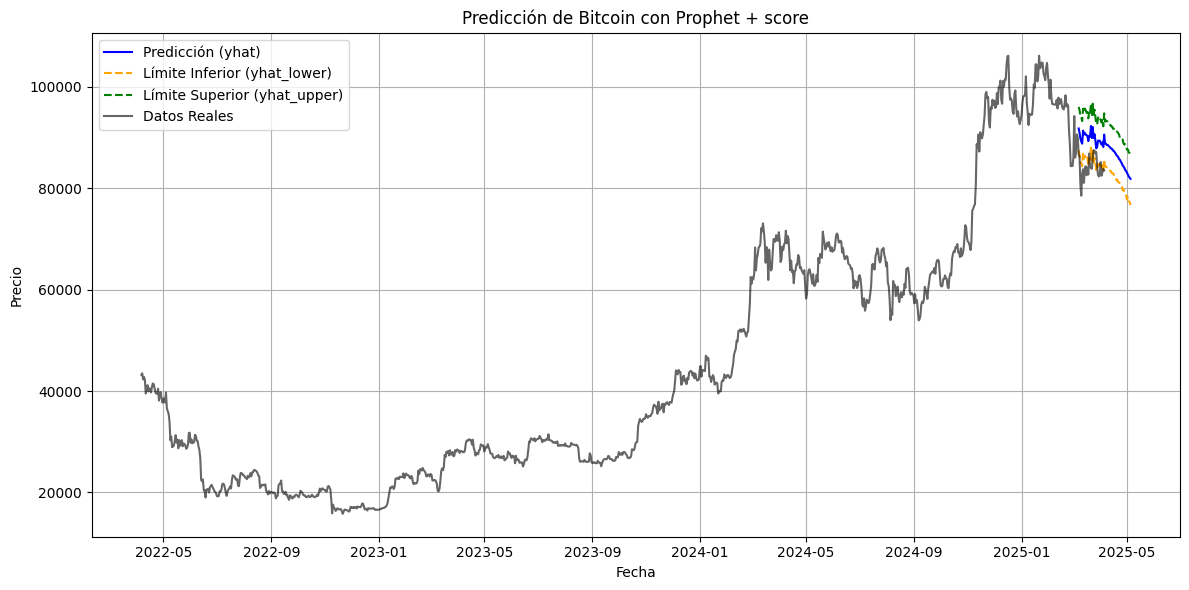

In [28]:
# Plot manual de las predicciones
plt.figure(figsize=(12, 6))

# Línea predicción central
plt.plot(pronostico['ds'][-60:], pronostico['yhat'][-60:], label='Predicción (yhat)', color='blue')

# Banda inferior
plt.plot(pronostico['ds'][-60:], pronostico['yhat_lower'][-60:], label='Límite Inferior (yhat_lower)', linestyle='--', color='orange')

# Banda superior
plt.plot(pronostico['ds'][-60:], pronostico['yhat_upper'][-60:], label='Límite Superior (yhat_upper)', linestyle='--', color='green')


# Opcional: la serie real (si está disponible)
if 'y' in df.columns:
    plt.plot(df['ds'], df['y'], label='Datos Reales', color='black', alpha=0.6)

plt.title("Predicción de Bitcoin con Prophet + score")
plt.xlabel("Fecha")
plt.ylabel("Precio")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Unimos el dataframe original (df) con las predicciones para fechas pasadas
df_evaluacion = pd.merge(df[['ds', 'y']], pronostico[['ds', 'yhat']], on='ds')

# Calcular MSE y RMSE
mse = mean_squared_error(df_evaluacion['y'], df_evaluacion['yhat'])
rmse = np.sqrt(mse)

# Mostrar resultados
print(f"📉 MSE (Error Cuadrático Medio): {mse:.2f}")
print(f"📉 RMSE (Raíz del Error Cuadrático Medio): {rmse:.2f}")


📉 MSE (Error Cuadrático Medio): 12589870.83
📉 RMSE (Raíz del Error Cuadrático Medio): 3548.22
